In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler, UniformSampler, ExponentialSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from cs285.agents.nueral_ode import Base_NeuralODE, NeuralODE_Vanilla, Pendulum_True_Dynamics, NeuralODE_Augmented, NeuralODE_Latent_MLP, ODE_RNN
from cs285.agents.utils import save_leaves, load_leaves
from cs285.infrastructure import utils
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import gym
from cs285.infrastructure import pytorch_util as ptu
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import pickle
from tqdm import trange
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [17]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [19]:
dt_sampler = ConstantSampler(dt=0.05)
env = PendulumEnv(
    dt_sampler=dt_sampler
)
ac_dim = env.action_space.shape[0]
ob_dim = env.observation_space.shape[0]
replay_buffer = ReplayBufferTrajectories(seed=42)
trajs, _ = sample_n_trajectories(env, RandomPolicy(env=env), ntraj=1000, max_length=200, key=key)
replay_buffer.add_rollouts(trajs)

100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


In [20]:
_neural_odes = {
    "vanilla": NeuralODE_Vanilla,
    "pendulum_true_dynamics": Pendulum_True_Dynamics,
    "augmented": NeuralODE_Augmented,
    "latent_mlp": NeuralODE_Latent_MLP,
    "ode_rnn": ODE_RNN
}


def train(neural_ode_name, neural_ode_kwargs, optimizer_name, optimizer_kwargs, train_config, replay_buffer):
    optimizer_class = getattr(optax, optimizer_name)
    optimizer = optimizer_class(**optimizer_kwargs)
    neural_ode = _neural_odes[neural_ode_name](**neural_ode_kwargs)
    opt_state = optimizer.init(eqx.filter(neural_ode, eqx.is_array))
    discount_array = train_config["discount"] ** jnp.arange(train_config["ep_len"])

    @eqx.filter_jit
    @eqx.filter_value_and_grad
    def get_loss_grad(neural_ode, obs, acs, times):
        obs_pred = neural_ode.batched_pred(ob=obs[:, 0, :], acs=acs, times=times)
        l2_losses = jnp.sum((obs - obs_pred) ** 2, axis=-1) # (batch_size, ep_len)
        weighed_mse = jnp.mean(discount_array * l2_losses)
        return weighed_mse

    @eqx.filter_jit
    def get_loss(neural_ode, obs, acs, times):
        obs_pred = neural_ode.batched_pred(ob=obs[:, 0, :], acs=acs, times=times)
        l2_losses = jnp.sum((obs - obs_pred) ** 2, axis=-1) # (batch_size, ep_len)
        return jnp.mean(l2_losses) # without discount

    def get_data():
        traj = replay_buffer.sample_rollouts(batch_size=train_config["batch_size"])
        obs = utils.split_arr(np.array(traj["observations"]), length=train_config["ep_len"], stride=train_config["stride"])
        acs = utils.split_arr(np.array(traj["actions"]), length=train_config["ep_len"], stride=train_config["stride"])
        dts = utils.split_arr(np.array(traj["dts"])[..., np.newaxis], length=train_config["ep_len"], stride=train_config["stride"]).squeeze(-1)
        batch_size, num_splitted, train_ep_len, ob_dim = obs.shape
        ac_dim = acs.shape[-1]
        obs = jnp.array(obs).reshape(batch_size * num_splitted, train_ep_len, ob_dim)
        acs = jnp.array(acs).reshape(batch_size * num_splitted, train_ep_len, ac_dim)
        times = jnp.cumsum(dts, axis=-1).reshape(batch_size * num_splitted, train_ep_len)
        return obs, acs, times

    losses = []
    for step in trange(train_config["steps"]):
        obs, acs, times = get_data()
        loss, grad = get_loss_grad(neural_ode, obs, acs, times)
        updates, opt_state = optimizer.update(grad, opt_state, neural_ode)
        neural_ode = eqx.apply_updates(neural_ode, updates)
        losses.append(loss.item())

    plt.plot(np.arange(len(losses)), losses)
    return neural_ode, losses
    

100%|██████████| 1000/1000 [1:45:51<00:00,  6.35s/it]


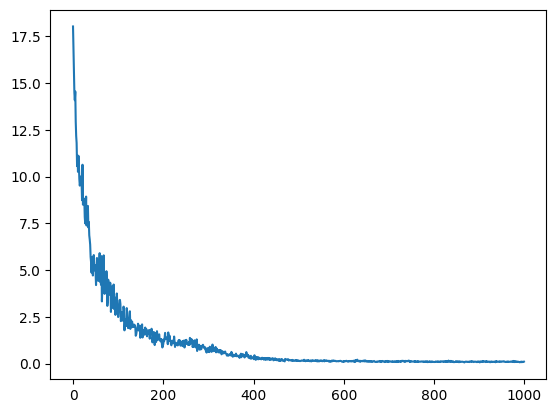

In [21]:
neural_ode_name = "vanilla"
neural_ode_kwargs = {
    "ode_dt0": 0.005,
    "mlp_dynamics_setup": {
        "hidden_size":128,
        "num_layers":4,
        "activation":"tanh",
        "output_activation":"identity"
    },
    "ac_dim": ac_dim,
    "ob_dim": ob_dim,
    "key": key
}
optimizer_name = "adamw"
optimizer_kwargs = {"learning_rate": 1e-3}
training_config = {
    "batch_size": 64,
    "steps": 1000,
    "ep_len": 20,
    "stride": 1,
    "discount": 1.0,
}
neural_ode, losses = train(neural_ode_name, neural_ode_kwargs, optimizer_name, optimizer_kwargs, training_config, replay_buffer)
save_leaves(neural_ode, "neural_ode_expr_1")

In [22]:
losses

[18.02497100830078,
 16.782440185546875,
 15.516372680664062,
 14.492866516113281,
 14.083365440368652,
 14.549052238464355,
 12.945351600646973,
 12.172040939331055,
 11.797075271606445,
 10.559114456176758,
 11.129841804504395,
 10.25462532043457,
 11.109916687011719,
 10.610603332519531,
 9.872244834899902,
 9.518010139465332,
 9.695145606994629,
 10.003531455993652,
 9.576908111572266,
 9.707042694091797,
 8.736648559570312,
 10.634379386901855,
 8.500713348388672,
 8.78262710571289,
 8.60427474975586,
 8.820362091064453,
 7.840932846069336,
 7.498286724090576,
 8.055516242980957,
 8.930971145629883,
 7.384536266326904,
 8.10606861114502,
 7.817989349365234,
 8.431158065795898,
 7.281991004943848,
 7.573415279388428,
 6.857643127441406,
 6.645151138305664,
 6.3641486167907715,
 5.702260494232178,
 5.420284748077393,
 4.8658037185668945,
 5.693833351135254,
 5.2815022468566895,
 4.712984085083008,
 5.509231090545654,
 5.8053412437438965,
 4.986462593078613,
 5.107189178466797,
 5.26

In [23]:
with open("neural_ode_expr_1_losses", "wb") as f:
    pickle.dump(losses, f)

In [6]:
key=jax.random.PRNGKey(0)
key1, key2 = jax.random.split(key)
dt_sampler = UniformSampler(low=0.10, high=0.00, key=key1)
env = PendulumEnv(
    dt_sampler=dt_sampler
)
ac_dim = env.action_space.shape[0]
ob_dim = env.observation_space.shape[0]
replay_buffer = ReplayBufferTrajectories()
trajs, _ = sample_n_trajectories(env, RandomPolicy(env=env), ntraj=1000, max_length=200, key=key2)
replay_buffer.add_rollouts(trajs)
with open("1000_uniform_0_0.1_replay_buffer", "wb") as f:
    pickle.dump(replay_buffer, f)

100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]


In [8]:
dt_sampler = ExponentialSampler(lmbda=20, key=key1)
env = PendulumEnv(
    dt_sampler=dt_sampler
)
ac_dim = env.action_space.shape[0]
ob_dim = env.observation_space.shape[0]
replay_buffer = ReplayBufferTrajectories()
trajs, _ = sample_n_trajectories(env, RandomPolicy(env=env), ntraj=1000, max_length=200, key=key2)
replay_buffer.add_rollouts(trajs)
with open("1000_exponential_20_replay_buffer", "wb") as f:
    pickle.dump(replay_buffer, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:41<00:00,  9.87it/s]
